In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
from utils.dataset import SmartwatchDataset, SmartwatchAugmentTransformer, get_file_lists
from utils.utils import load_checkpoint_Transformer
from model.Transformer import TransformerModel

In [2]:
# Get .csv files
train_files, val_files, test_files = get_file_lists(
    val_sub_list=['05', 10, 15, 20, 25, 30],
    test_sub_list=[35],
)
BATCH_SIZE = 16
# Get dataloaders
train_dataset = SmartwatchDataset(train_files)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=SmartwatchAugmentTransformer(max_input_samples=1024, downsample_output_seq=2), drop_last=True, shuffle=True)

val_dataset = SmartwatchDataset(val_files)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=SmartwatchAugmentTransformer(max_input_samples=1024, downsample_output_seq=2), drop_last=True, shuffle=True)

test_dataset = SmartwatchDataset(test_files)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=SmartwatchAugmentTransformer(max_input_samples=1024, downsample_output_seq=2), drop_last=True, shuffle=False)


In [3]:
batch = next(iter(test_loader))
targets = batch["targets"]

In [4]:
# Convert into real world positions by multiplying by standard deviation
from scipy.spatial.transform import Rotation

i = 1
pos = targets[i, 512:, 0:3].cpu().numpy()
quat = targets[i, 512:, 3:].cpu().numpy()

In [14]:
def plot_line(ax, coords, c='k', **kwargs):
    ax.plot(coords[:, 0], coords[:, 1], zs=coords[:, 2], c=c, **kwargs)
    return ax

def plot_path_and_normal_vec(pos, quat, start=0, stop=100):
    """
    pos: (N, 3) array of positions
    quat: (N, 4) array of quaternion values
    """
    rot = Rotation.from_quat(quat).as_matrix()
    norm_vecs = -1 * rot[:, 0, :]  # Want negative x basis as the normal vec to smartwatch on wrist

    inds = slice(start, stop)

    xs = pos[inds, 0]
    ys = pos[inds, 1]
    zs = pos[inds, 2]

    # Plot position trajectory
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(xs, ys, zs=zs)

    # Plot normal vectors at each timepoint
    for i in range(*inds.indices(512)):
        origin = pos[i, :]
        delta = norm_vecs[i, :]
        ax = plot_line(ax, np.vstack([origin, origin + 0.1 * delta]), c='r', lw=0.5)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

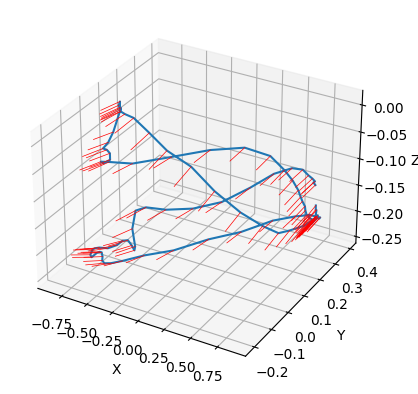

In [18]:
i = 1
pos = targets[i, 512:, 0:3].cpu().numpy()
quat = targets[i, 512:, 3:].cpu().numpy()

plot_path_and_normal_vec(pos, quat, start=400, stop=512)

In [14]:
# Test 1 model
path = "/root/trevor/syde770-project/best_models/cnn-transformer/17-04-2023_160328/outputs.npy"
outputs = np.load(path, allow_pickle=True)

In [15]:
outputs.shape

(4, 4, 512, 7)

In [16]:
outputs[0]

array([[[-0.886776328086853, 0.9258715510368347, 0.7162237167358398,
         ..., 0.5241091847419739, -0.5344870090484619,
         -0.6651170253753662],
        [-0.820083498954773, 0.7844195365905762, 0.6854265928268433,
         ..., 0.5508378148078918, -0.5118796825408936,
         -0.6690364480018616],
        [-0.7459814548492432, 0.632084310054779, 0.642136812210083, ...,
         0.5652723908424377, -0.48449239134788513, -0.684597373008728],
        ...,
        [1.3867653608322144, -0.3411802351474762, -0.6175310611724854,
         ..., -0.24246956408023834, -0.0057180412113666534,
         0.946639358997345],
        [1.3802601099014282, -0.35087987780570984, -0.6175537109375,
         ..., -0.24078628420829773, -0.0012072362005710602,
         0.9476221799850464],
        [1.3674567937850952, -0.3606207072734833, -0.6136587262153625,
         ..., -0.23650510609149933, 0.004110153764486313,
         0.9487364888191223]],

       [[0.10265184193849564, 0.6928232908248901, -2

In [17]:
outputs[0, 0, :, :].shape

(512, 7)